# ⚽ Simulador Mundial FIFA 2026

## Metodología:
1. **Elo Rating**: Fuerza de equipos basada en historial
2. **Random Forest**: Predicción de resultados (W/D/L)
3. **Simulación Monte Carlo**: n iteraciones del torneo completo
4. **Métricas**: Probabilidades, goleadores, tarjetas, grupos de la muerte, etc

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

# 1️⃣ **Carga y Preparación de Datos**

In [2]:
# Cargar datasets
df_results = pd.read_csv('results.csv', parse_dates=['date'])
df_goals = pd.read_csv('goalscorers.csv')
df_cards = pd.read_csv('worldcup_cards_by_team_tournament.csv')
df_former = pd.read_csv('former_names.csv')
df_fifa  = pd.read_csv('players_22.csv')

Text(0.5, 1.0, 'Conteo: minutes')

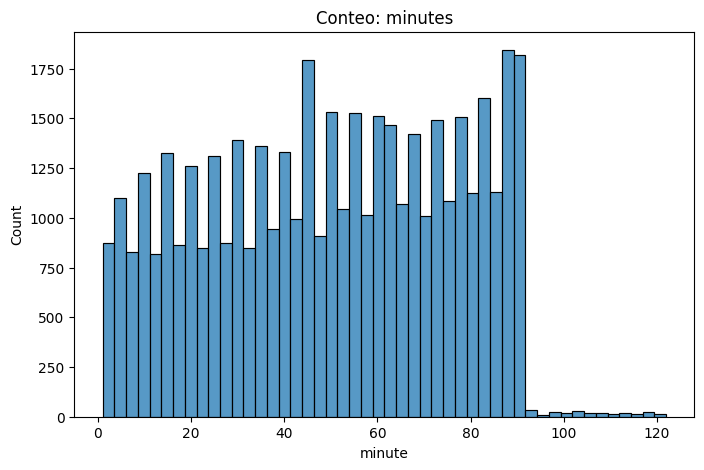

In [3]:
plt.figure(figsize=(8,5))
sns.histplot(x="minute", data=df_goals)
plt.title("Conteo: minutes")

### ⏱️ Análisis Temporal: Distribución de Goles por Minuto

Este histograma ilustra la frecuencia con la que se marcan goles en cada minuto de juego a lo largo de la historia reciente de los partidos internacionales.

* **Eje Horizontal (X):** Minuto del partido (0 a 90+).
* **Eje Vertical (Y):** Cantidad total de goles anotados en ese minuto específico.

* **Interpretación de Tendencias:**
    * **Efecto de Fatiga y Cierre:** Se observan dos picos claros y pronunciados alrededor del **minuto 45** y el **minuto 90**. Esto confirma la teoría de que la concentración defensiva tiende a romperse justo antes del descanso y al final del partido, cuando la fatiga física y mental es máxima.
    * **Inicio Táctico:** Los primeros minutos (0-15) suelen mostrar una frecuencia menor, reflejando una fase de estudio inicial donde los equipos arriesgan menos.
    * **Impacto en la Simulación:** Este patrón valida la importancia de considerar la resistencia física y los cambios tácticos en los últimos tramos del partido para predecir resultados ajustados.

In [4]:
# Función reutilizable para unificar nombres de países en distintos DataFrames
def standardize_country_names(df, columns, former_df):
    """
    Reemplaza nombres antiguos o variantes por el nombre estándar actual.
    df: DataFrame a modificar | columns: Columna(s) a limpiar | former_df: Tabla de referencia (antiguo->nuevo)
    """
    # Crea un diccionario maestro 'Antiguo' -> 'Nuevo' desde el CSV de referencia
    mapping = dict(zip(former_df['former'], former_df['current']))
    
    # Diccionario de correcciones manuales para casos que no están en el CSV o son variantes de idioma
    manual = {
        'United States': 'USA',          # Unifica a siglas
        'Korea Republic': 'South Korea', # Nombre común vs oficial FIFA
        'Czech Republic': 'Chequia',     # Nombre moderno corto
        'IR Iran': 'Iran'                # Quita prefijos burocráticos
    }
    mapping.update(manual)               # Fusiona las correcciones manuales con el diccionario principal
    
    # Asegura que 'columns' sea siempre una lista, incluso si el usuario pasó solo un string ('columna')
    if isinstance(columns, str):
        columns = [columns]
    
    # Itera sobre las columnas solicitadas y aplica el reemplazo masivo
    for col in columns:
        if col in df.columns:                       # Verifica que la columna exista para evitar errores
            df[col] = df[col].replace(mapping)      # Aplica el diccionario de traducción a toda la columna
    return df                                       # Devuelve el DataFrame modificado

# --- EJECUCIÓN DE LA LIMPIEZA ---

# Aplica la estandarización a los equipos local y visitante en el histórico de partidos
df_results = standardize_country_names(df_results, ['home_team', 'away_team'], df_former)

# Aplica la misma estandarización al dataset de goleadores para asegurar consistencia al cruzar datos
df_goals = standardize_country_names(df_goals, 'team', df_former)

# Imprime confirmación con el total de registros procesados
print(f"✓ Datos cargados: {len(df_results):,} partidos históricos")

✓ Datos cargados: 48,943 partidos históricos


# 2️⃣ **Algoritmo Elo Rating**

In [5]:
def calculate_elo(df, start_year=1990, k=30):
    """Calcula Elo ratings - versión simplificada y eficiente."""
    elo = {}  # Diccionario para guardar el rating actual de cada país
    
    # Filtra datos antiguos y ordena cronológicamente (CRUCIAL: el Elo depende del orden temporal)
    df_recent = df[df['date'].dt.year >= start_year].sort_values('date')
    
    for _, row in df_recent.iterrows():                # Itera fila por fila (partido a partido)
        home, away = row['home_team'], row['away_team']
        
        # Inicialización: Si el equipo es nuevo en el sistema, arranca con 1500 (promedio estándar)
        elo.setdefault(home, 1500)
        elo.setdefault(away, 1500)
        
        # 1. Probabilidad Esperada: ¿Qué tan probable es que gane el local?
        # Usa la diferencia de rating. El divisor 600 suaviza la curva de probabilidad.
        exp_home = 1 / (1 + 10 ** ((elo[away] - elo[home]) / 600))
        
        # 2. Resultado Real del partido (Variable 'S' en la fórmula Elo)
        if row['home_score'] > row['away_score']:
            actual = 1                                 # Victoria Local (100% de los puntos)
        elif row['home_score'] < row['away_score']:
            actual = 0                                 # Derrota Local (0% de los puntos)
        else:
            actual = 0.5                               # Empate (Reparto de puntos)
        
        # 3. Factor de Importancia: Dar más peso a partidos del Mundial hace el ranking más realista
        importance = 1.5 if row['tournament'] == 'FIFA World Cup' else 1.0
        
        # 4. Cálculo del Delta (Cambio de Puntos):
        # Fórmula: K * Importancia * (Lo que pasó realmente - Lo que se esperaba que pasara)
        # Si ganaste (1) pero se esperaba que perdieras (0.2), subes mucho.
        delta = k * importance * (actual - exp_home)
        
        elo[home] += delta                             # El local suma (o resta si delta es negativo)
        elo[away] -= delta                             # El visitante recibe el opuesto (suma cero)
    
    return elo

# Ejecución del cálculo usando el DataFrame de resultados históricos
elo_ratings = calculate_elo(df_results)

# Convierte el diccionario a Serie, ordena de mayor a menor y muestra el Top 10
top_elo = pd.Series(elo_ratings).sort_values(ascending=False).head(10)
print("\n🏆 Top 10 Elo Rating:")
print(top_elo.to_string())


🏆 Top 10 Elo Rating:
Argentina      2199.647779
Spain          2192.839760
France         2132.796249
Brazil         2084.557950
England        2076.089817
Colombia       2068.446471
Portugal       2045.058661
Netherlands    2034.923349
Germany        2016.859233
Japan          2003.129904


# 3️⃣ **Modelo Predictivo Random Forest Classifier**

In [6]:
def train_model(df, elo, min_year=2010):
    """
    Entrena un modelo de clasificación (Random Forest) para predecir el resultado de un partido.
    Utiliza la diferencia de ranking Elo y el factor de localía como variables predictoras.
    """
    
    # 1. FILTRADO DE DATOS (HISTORIA MODERNA)
    # Usamos solo partidos desde 2010 para que el modelo aprenda tendencias actuales y no de hace 50 años.
    df_train = df[df['date'].dt.year >= min_year]
    
    X, y = [], []  # Listas para: X (Variables explicativas/Inputs) e y (Resultado/Target)

    # 2. INGENIERÍA DE CARACTERÍSTICAS (FEATURE ENGINEERING)
    for _, row in df_train.iterrows():
        h, a = row['home_team'], row['away_team']
        
        # Solo usamos partidos donde conocemos el Elo de ambos equipos
        if h in elo and a in elo:
            
            # --- CREACIÓN DE 'X' (LO QUE EL MODELO VE) ---
            # Dato 1: Diferencia de Elo (Elo Local - Elo Visitante). 
            #         Positivo = Local es más fuerte. Negativo = Visitante es más fuerte.
            # Dato 2: Factor Cancha (1 si es neutral, 0 si hay localía real).
            X.append([elo[h] - elo[a], 1 if row['neutral'] else 0])
            
            # --- CREACIÓN DE 'y' (LO QUE EL MODELO DEBE PREDECIR) ---
            # Convertimos el marcador en 3 clases numéricas:
            if row['home_score'] > row['away_score']:
                y.append(2)  # CLASE 2: Gana Local
            elif row['home_score'] < row['away_score']:
                y.append(0)  # CLASE 0: Gana Visitante
            else:
                y.append(1)  # CLASE 1: Empate
    
    # Convertimos listas a Arrays de Numpy (formato óptimo para Scikit-Learn)
    X, y = np.array(X), np.array(y)
    
    # 3. DIVISIÓN ENTRENAMIENTO / PRUEBA (TRAIN/TEST SPLIT)
    # Separamos el 20% de los datos (test_size=0.2) para hacer un "examen final" al modelo 
    # y verificar que no esté simplemente memorizando los resultados.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 4. CONFIGURACIÓN DEL MODELO (RANDOM FOREST)
    # Usamos un "Bosque Aleatorio" porque maneja bien datos no lineales y reduce el riesgo de sobreajuste.
    # n_estimators=100: Crea 100 árboles de decisión y vota el resultado final.
    # max_depth=5: Limita la complejidad de cada árbol (evita que memorice ruido).
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    
    # 5. ENTRENAMIENTO (FITTING)
    # El modelo aprende la relación matemática entre la diferencia de Elo y el resultado.
    model.fit(X_train, y_train)
    
    # 6. EVALUACIÓN (SCORING)
    # Probamos el modelo con los datos que NUNCA vio (X_test) para ver su precisión real.
    accuracy = model.score(X_test, y_test)
    print(f"\n✓ Modelo entrenado - Precisión: {accuracy:.1%}")
    
    return model, X_test, y_test # Devolvemos el modelo ya entrenado listo para hacer predicciones futuras

# Ejecución: Le pasamos el histórico de partidos y los ratings calculados previamente
predictor, X_test, y_test = train_model(df_results, elo_ratings)


✓ Modelo entrenado - Precisión: 61.5%


# 4️⃣ **Motor de Simulación Monte Carlo**

In [7]:
def simulate_match(team_a, team_b, knockout=False):
    """
    Simula un partido individual utilizando el modelo de Machine Learning y azar controlado.
    
    Parámetros:
    - knockout: Si es True, fuerza un ganador (simulando penales si hay empate).
    """
    # 1. Obtener Ratings (Fuerza de los equipos)
    # Si el equipo no existe en el diccionario (ej. un país muy pequeño), asumimos 1500 (promedio).
    elo_a = elo_ratings.get(team_a, 1500)
    elo_b = elo_ratings.get(team_b, 1500)
    
    # 2. Predicción Probabilística (Random Forest)
    # El modelo recibe: [Diferencia de Elo, Factor de Cancha Neutral (1)]
    # Devuelve un array de probabilidades: [Prob. Gana B, Prob. Empate, Prob. Gana A]
    probs = predictor.predict_proba([[elo_a - elo_b, 1]])[0]
    
    # 3. Factor Aleatorio (Monte Carlo)
    # Elegimos el resultado al azar respetando las probabilidades del modelo.
    # 0 = Gana B (Visitante), 1 = Empate, 2 = Gana A (Local)
    result = np.random.choice([0, 1, 2], p=probs)
    
    if knockout: 
        if result == 1:  # Si el simulador dice "Empate"... vamos a Penales.
            
            # Penales:
            # Base 50% + una ventaja técnica derivada de la diferencia de Elo.
            # Dividir por 2000 suaviza la ventaja: un equipo mucho mejor tiene aprox 60% en penales.
            prob_a = 0.5 + (elo_a - elo_b) / 2000
            
            # Decisión final de penales
            result = 2 if np.random.random() < prob_a else 0
            
        # Retornamos el NOMBRE del ganador para avanzar en el bracket
        return team_a if result == 2 else team_b
        
    else:
        # --- LÓGICA DE FASE DE GRUPOS ---
        # Retornamos los PUNTOS para la tabla (3 para el ganador, 1 empate, 0 perdedor)
        # Formato: (Puntos Equipo A, Puntos Equipo B)
        return (3, 0) if result == 2 else ((0, 3) if result == 0 else (1, 1))

def simulate_group(teams):
    """
    Simula los 6 partidos de un grupo (todos contra todos) y genera la tabla de posiciones.
    Ahora retorna también los puntos exactos obtenidos.
    """
    # Estructura de datos para la tabla: Puntos (pts) y Diferencia de Goles (gd)
    standings = {t: {'pts': 0, 'gd': 0} for t in teams}
    
    # Doble bucle para el Todos contra todos una sola vez
    for i in range(len(teams)):
        for j in range(i + 1, len(teams)):
            # Simulamos el partido y obtenemos la repartición de puntos
            pts_a, pts_b = simulate_match(teams[i], teams[j])
            
            # Sumamos puntos en la tabla
            standings[teams[i]]['pts'] += pts_a
            standings[teams[j]]['pts'] += pts_b
            
            # Implementación Diferencia de Goles:
            # Usamos la diferencia de puntos del partido como proxy de goles.
            # Si ganaste (3-0 en puntos), asumimos +3 GD. Es una simplificación eficiente para no simular marcadores exactos.
            standings[teams[i]]['gd'] += (pts_a - pts_b)
            standings[teams[j]]['gd'] += (pts_b - pts_a)
    
    # Ordenamos la tabla:
    # 1. Mayor cantidad de puntos ('pts')
    # 2. Mejor diferencia de goles ('gd')
    # reverse=True pone a los mejores arriba
    sorted_teams = sorted(standings.items(), key=lambda x: (x[1]['pts'], x[1]['gd']), reverse=True)
    
    # 1. Lista de los 2 clasificados directos.
    # 2. El nombre del 3ro (para ver si entra por repechaje).
    # 3. 'standings': El diccionario completo con los puntos (NUEVO para el cálculo de promedios).
    return [t[0] for t in sorted_teams[:2]], sorted_teams[2][0], standings

def resolve_playoffs():
    """Resuelve los repechajes previos (UEFA e Intercontinentales) para completar los 48 equipos."""
    # Lambda helper: simula un partido knockout rápido entre t1 y t2
    def ko(t1, t2): return simulate_match(t1, t2, knockout=True)
    
    winners = {}
    # Rutas UEFA: Formato de semifinal y final a partido único
    # Ejemplo Path A: (Italia vs Irlanda) vs (Gales vs Bosnia) -> Ganador va al mundial
    winners['UEFA_A'] = ko(ko('Italy', 'Northern Ireland'), ko('Wales', 'Bosnia and Herzegovina'))
    winners['UEFA_B'] = ko(ko('Ukraine', 'Sweden'), ko('Poland', 'Albania'))
    winners['UEFA_C'] = ko(ko('Turkey', 'Romania'), ko('Slovakia', 'Kosovo'))
    winners['UEFA_D'] = ko(ko('Denmark', 'North Macedonia'), ko('Chequia', 'Republic of Ireland'))
    
    # Repechajes Intercontinentales (Ida y vuelta simplificada a un KO)
    winners['IC_1'] = ko(ko('Bolivia', 'Suriname'), 'Iraq')
    winners['IC_2'] = ko(ko('New Caledonia', 'Jamaica'), 'DR Congo')
    
    return winners # Diccionario con los nombres de los 6 equipos extra que clasificaron

def run_tournament():
    """
    Función Maestra (Orquestador): Ejecuta UNA simulación completa del Mundial 2026.
    Desde los grupos hasta levantar la copa.
    """
    # 1. Llenamos los cupos vacíos con los ganadores del repechaje
    pw = resolve_playoffs()
    
    # 2. Definición de Grupos (Formato 2026: 12 grupos de 4 equipos)
    groups = {
        'A': ['Mexico', 'South Africa', 'South Korea', pw['UEFA_D']],
        'B': ['Canada', pw['UEFA_A'], 'Qatar', 'Switzerland'],
        'C': ['Brazil', 'Morocco', 'Haiti', 'Scotland'],
        'D': ['USA', 'Paraguay', 'Australia', pw['UEFA_C']],
        'E': ['Germany', 'Curaçao', 'Ivory Coast', 'Ecuador'],
        'F': ['Netherlands', 'Japan', pw['UEFA_B'], 'Tunisia'],
        'G': ['Belgium', 'Egypt', 'Iran', 'New Zealand'],
        'H': ['Spain', 'Cape Verde', 'Saudi Arabia', 'Uruguay'],
        'I': ['France', 'Senegal', pw['IC_1'], 'Norway'],
        'J': ['Argentina', 'Algeria', 'Austria', 'Jordan'],
        'K': ['Portugal', pw['IC_2'], 'Uzbekistan', 'Colombia'],
        'L': ['England', 'Croatia', 'Ghana', 'Panama']
    }
    
    # 3. Simulación de Fase de Grupos
    r32, thirds, winners = [], [], []
    all_points = {} # Diccionario acumulador para los puntos de esta simulación
    
    for teams in groups.values():
        # Desempaquetamos los 3 valores que retorna ahora simulate_group
        top2, third, group_standings = simulate_group(teams)
        
        r32.extend(top2)                              # Los top 2 van directo a 16avos
        thirds.append((third, elo_ratings.get(third, 1500))) # Guardamos al 3ro con su Elo
        winners.append(top2[0])                       # Guardamos al ganador del grupo
        
        # --- CAPTURA DE PUNTOS ---
        # Extraemos los puntos de cada equipo en este grupo y los guardamos en el diccionario general
        for team, data in group_standings.items():
            all_points[team] = data['pts']
    
    # 4. Definición de Mejores Terceros
    # De los 12 terceros, clasifican los 8 mejores.
    # Criterio de desempate simulado: Mayor Elo (asumiendo que los fuertes ganan los desempates complejos)
    best_thirds = [t[0] for t in sorted(thirds, key=lambda x: x[1], reverse=True)[:8]]
    r32.extend(best_thirds)                           # Completamos el cuadro de 32 equipos
    
    # 5. Fase Eliminatoria 
    
    # Sembrado: Ordenamos a los 32 clasificados por Elo.
    # Simula que la FIFA empareja a los mejores contra los peores en 16avos.
    r32_sorted = sorted(r32, key=lambda t: elo_ratings.get(t, 1500), reverse=True)
    
    # 16avos de Final (R32): El 1ro vs el 32vo, el 2do vs el 31vo...
    r16 = [simulate_match(r32_sorted[i], r32_sorted[31-i], knockout=True) for i in range(16)]
    
    # Octavos de Final (De 16 a 8): Simulamos de a pares adyacentes
    quarters = [simulate_match(r16[i], r16[i+1], knockout=True) for i in range(0, 8, 2)]
    
    # Cuartos de Final (De 8 a 4)
    semis = [simulate_match(quarters[i], quarters[i+1], knockout=True) for i in range(0, 4, 2)]
    
    # Final (El partido por el título)
    champion = simulate_match(semis[0], semis[1], knockout=True)
    
    # 6. Retorno de Resultados de esta Simulación
    return {
        'Champion': champion,
        'Finalists': semis,       # Finalistas
        'Semis': quarters,        # Semifinalistas
        'Quarters': r16,          # Cuartofinalistas
        'R32': r32,               # Los 32 que pasaron de grupos
        'GroupWinners': winners,  # Ganadores de grupo
        'Groups': groups,         # Configuración de grupos
        'Points': all_points      # NUEVO: Puntos obtenidos por cada equipo (para promedios)
    }

print("✓ Motor de simulación listo")

✓ Motor de simulación listo


# 5️⃣ **Ejecución Monte Carlo n Simulaciones**

In [8]:
N_SIMS = 300  # Número de iteraciones Monte Carlo.

# Diccionario acumulador: Aquí guardaremos TODOS los resultados de los 300 mundiales.
results = {
    'Champion': [],      # Lista de campeones (tendrá 300 elementos al final)
    'Finalists': [],     # Lista de finalistas (tendrá 600 elementos: 2 por mundial)
    'Semis': [],         # Semifinalistas (1200 elementos)
    'Quarters': [],      # Cuartofinalistas
    'R32': [],           # Clasificados a 16avos
    'GroupWinners': []   # Ganadores de grupo
}

saved_groups = {}  # Variable para guardar una "foto" de cómo quedaron los grupos en la primera simulación

total_points = {}  # Variable para acumular puntos obtenidos por cada equipo a lo largo de todas las simulaciones

print(f"🎲 Ejecutando {N_SIMS:,} simulaciones...")

# --- BUCLE PRINCIPAL ---
for i in range(N_SIMS):
    
    # Monitor de progreso: Imprime un aviso cada 50 simulaciones para saber que el código sigue vivo.
    if (i + 1) % 50 == 0:
        print(f"   Progreso: {i+1:,}/{N_SIMS:,} ({(i+1)/N_SIMS:.0%})")
    
    # 1. Ejecutar un torneo completo
    # Llama a la función maestra que simula desde grupos hasta la final y devuelve un diccionario con los ganadores de esa iteración.
    sim = run_tournament()

    # 2. Guardar estructura de grupos (Solo una vez)
    # Como los grupos se generan dinámicamente (por los repechajes), guardamos la configuración
    # del primer mundial (i==0) para poder analizar luego cosas como el "Grupo de la Muerte".
    if i == 0:
        saved_groups = sim['Groups']
    # Acumular puntos totales por equipo
        total_points = {t: 0 for t in sim['Points'].keys()}
    
    # 3. Almacenar resultados (Agregación de Datos)
    
    # .append(): Agrega UN elemento a la lista. (Solo hay 1 campeón por simulación)
    results['Champion'].append(sim['Champion'])
    
    # .extend(): Agrega el CONTENIDO de una lista a otra.
    # 'sim['Finalists']' es una lista de 2 equipos (ej: ['Argentina', 'France']).
    # Queremos que la lista principal crezca con esos nombres, no que guarde listas dentro de listas.
    results['Finalists'].extend(sim['Finalists'])
    results['Semis'].extend(sim['Semis'])
    results['Quarters'].extend(sim['Quarters'])
    results['R32'].extend(sim['R32'])
    results['GroupWinners'].extend(sim['GroupWinners'])
    # Acumular puntos totales por equipo
    for team, pts in sim ['Points'].items():
        if team in total_points:
            total_points[team] += pts
        else:
            total_points[team] = pts 

print("\n✅ Simulaciones completadas")

🎲 Ejecutando 300 simulaciones...
   Progreso: 50/300 (17%)
   Progreso: 100/300 (33%)
   Progreso: 150/300 (50%)
   Progreso: 200/300 (67%)
   Progreso: 250/300 (83%)
   Progreso: 300/300 (100%)

✅ Simulaciones completadas


# 6️⃣ **Análisis de Resultados**

In [ ]:
# --- CÁLCULO DE ESTADÍSTICAS FINALES ---

# 1. Definir el Universo de Equipos
# Usamos set() para obtener una lista única de equipos que llegaron al menos a 16avos.
# Esto filtra automáticamente a equipos irrelevantes que nunca pasaron de fase de grupos.
teams = set(results['R32']) 

probs = []  # Lista acumuladora para las estadísticas de cada país

# 2. Bucle de Cálculo de Probabilidades
for team in teams:
    probs.append({
        'Team': team,
        
        # --- Promedio de Puntos en Fase de Grupos ---
        # Fórmula: (Suma Total de Puntos obtenidos en 300 mundiales) / 300
        # .get(team, 0) es un seguro: si por error un equipo no tiene datos, devuelve 0 en vez de fallar.
        'Avg_Pts': total_points.get(team, 0) / N_SIMS, 
        
        # --- Probabilidades de Avance (Frecuencia Relativa) ---
        # Fórmula: (Veces que ocurrió el evento) / (Total Simulaciones)
        # Ejemplo: Si ganó el grupo 150 veces de 300 -> 0.5 (50%)
        'Win Group': results['GroupWinners'].count(team) / N_SIMS,
        'R32': results['R32'].count(team) / N_SIMS,             # Prob. Clasificar
        'Quarters': results['Quarters'].count(team) / N_SIMS,   # Prob. Top 8
        'Semis': results['Semis'].count(team) / N_SIMS,         # Prob. Top 4
        'Final': results['Finalists'].count(team) / N_SIMS,     # Prob. Finalista
        'Champion': results['Champion'].count(team) / N_SIMS    # Prob. Campeón
    })

# 3. Creación del DataFrame
# Convertimos la lista de diccionarios en una tabla de Pandas.
# Ordenamos por 'Champion' descendente para que los favoritos al título aparezcan primero.
df_probs = pd.DataFrame(probs).sort_values('Champion', ascending=False)

# Filtro de seguridad: Eliminamos cualquier fila vacía o error (equipos con 0% de R32)
df_probs = df_probs[df_probs['R32'] > 0]

# 4. Copia para Display
# Hacemos una copia (.copy()) para no modificar df_probs.
df_display = df_probs.copy()

# 5. Formato de Puntos (Texto)
# Redondeamos a 1 decimal y convertimos a texto. Ej: 5.382 -> 5.4 -> "5.4"
df_display['Avg_Pts'] = df_display['Champion'].round(1).astype(str) 

# 6. Formato de Porcentajes
# Iteramos sobre las columnas de probabilidad para hacerlas legibles a humanos.
for col in ['Win Group', 'R32', 'Quarters', 'Semis', 'Final', 'Champion']:
    # Multiplicamos por 100, redondeamos y agregamos el símbolo '%'
    # Ejemplo: 0.156 -> 15.6 -> "15.6%"
    df_display[col] = (df_display[col] * 100).round(1).astype(str) + '%'

# 7. Reordenamiento de Columnas
# Movemos 'Avg_Pts' al inicio, justo después del nombre del equipo.
# Esto da una narrativa lógica: Puntos en Grupo -> Probabilidad de avanzar rondas -> Probabilidad de Campeón.
cols = ['Team', 'Avg_Pts', 'Win Group', 'R32', 'Quarters', 'Semis', 'Final', 'Champion']
df_display = df_display[cols]

# 8. Imprimir Resultados
print("\n🏆 TOP CANDIDATOS AL TÍTULO (Ordenado por Probabilidad de Campeón):")
display(df_display.head(15))


🏆 TOP CANDIDATOS AL TÍTULO (Ordenado por Probabilidad de Campeón):


,Team,Avg_Pts,Win Group,R32,Quarters,Semis,Final,Champion
36,Spain,0.2,82.7%,99.0%,90.3%,44.0%,29.7%,20.7%
29,Argentina,0.2,81.3%,99.3%,94.7%,53.0%,32.0%,19.7%
53,France,0.2,75.0%,97.7%,89.0%,59.3%,23.7%,15.3%
14,England,0.1,62.7%,98.0%,77.7%,49.7%,28.3%,12.0%
45,Portugal,0.1,52.3%,97.7%,76.0%,46.7%,26.3%,9.0%
9,Brazil,0.1,64.7%,98.3%,74.7%,31.7%,12.7%,7.3%
21,Colombia,0.1,36.0%,92.3%,70.0%,33.7%,18.3%,6.3%
25,Netherlands,0.0,55.3%,94.3%,67.7%,34.3%,17.7%,5.0%
52,Germany,0.0,62.0%,98.7%,70.0%,11.0%,4.7%,3.0%
59,Canada,0.0,37.3%,91.3%,30.7%,4.3%,1.3%,0.7%


# 7️⃣**Métricas Adicionales**
## Tarjetas

In [10]:
# 1. Estandarización de nombres
# Normalizamos los nombres en la tabla de tarjetas para que coincidan con el resto del proyecto.
# Ejemplo: 'West Germany' se convierte en 'Germany' para sumar su historial completo.
df_cards = standardize_country_names(df_cards, 'team_name', df_former)

# 2. Creación de la métrica "Total de Tarjetas"
# Sumamos amarillas y rojas para tener un indicador único de indisciplina.
df_cards['total_cards'] = df_cards['yellow_cards'] + df_cards['red_cards']

# 3. Cálculo del Promedio Histórico
# Agrupamos por país y calculamos la media de tarjetas que reciben por cada torneo jugado.
# reset_index convierte el resultado de GroupBy de vuelta a un DataFrame limpio.
avg_cards = df_cards.groupby('team_name')['total_cards'].mean().reset_index()

# Renombramos columnas para estandarizar: 'Team' será la clave para cruzar datos más adelante.
avg_cards.columns = ['Team', 'Avg_Cards_Per_Tournament']

# 4. Definición del Universo Competitivo (Top 48)
# Usamos 'df_probs' (resultado de la simulación) para obtener los 48 equipos con más chances de ir al Mundial.
top_teams = df_probs.head(48)['Team'].tolist()

# 5. Filtrado y Ranking
# Filtramos la tabla histórica 'avg_cards' conservando solo a esos 48 candidatos.
# Ordenamos descendente: Arriba quedarán los equipos históricamente más "agresivos" o tarjeteados.
discipline_proj = avg_cards[avg_cards['Team'].isin(top_teams)].sort_values(
    'Avg_Cards_Per_Tournament', ascending=False
)

# 6. Salida de Resultados
print("Top Equipos con Mayor Promedio Histórico de Tarjetas en Mundiales:")
display(discipline_proj.head(10))

Top Equipos con Mayor Promedio Histórico de Tarjetas en Mundiales:


,Team,Avg_Cards_Per_Tournament
75,Ukraine,13.000000
43,Netherlands,12.000000
63,Slovakia,12.000000
49,Panama,11.000000
2,Argentina,10.846154
34,Iraq,10.000000
17,Croatia,10.000000
26,Germany,9.875000
60,Senegal,9.333333
69,Switzerland,8.500000


## Análisis de dificultad de grupos (grupos de la muerte)

In [11]:
# Recuperamos la configuración de grupos guardada en la primera iteración.
# Esto es necesario porque los grupos se generan dinámicamente con los repechajes.
groups_analysis = saved_groups 
group_difficulty = []

# Iteramos sobre cada grupo (A, B, C...) y su lista de equipos
for g_name, teams in groups_analysis.items():
    
    # 1. Cálculo de la Fuerza Promedio del Grupo
    # Obtenemos el Elo de cada integrante (usando 1500 si no tiene dato) y sacamos la media.
    avg_elo = np.mean([elo_ratings.get(t, 1500) for t in teams])
    
    # 2. Identificación del Cabeza de Serie (Techo de Dificultad)
    # Buscamos cuál es el equipo con el Elo máximo dentro del grupo.
    # Sirve para saber quién es el "monstruo" o favorito a vencer en esa zona.
    top_team = max(teams, key=lambda x: elo_ratings.get(x, 1500))
    
    # Guardamos los datos calculados en la lista
    group_difficulty.append({
        'Grupo': f"Grupo {g_name}",
        'Avg_Elo': round(avg_elo, 0),    # Redondeamos para que el reporte quede limpio (sin decimales)
        'Top_Seed': top_team,            # El equipo más fuerte
        'Dificultad': ''                 # Espacio vacío para llenar luego con la etiqueta de texto
    })

# 3. Creación del Ranking
# Convertimos a DataFrame y ordenamos por Elo Promedio descendente.
# El primer registro será el "Grupo de la Muerte".
df_group_difficulty = pd.DataFrame(group_difficulty).sort_values('Avg_Elo', ascending=False)

# 4. Función de Categorización Visual
def categorize_diff(elo):
    """Asigna una etiqueta de texto legible según el nivel numérico del Elo."""
    if elo > 1900: return 'Pesadilla'     # Grupo extremo
    elif elo > 1850: return 'Muy Difícil' # Grupo complicado
    elif elo > 1800: return 'Competitivo' # Grupo estándar de mundial
    else: return 'Accesible'              # Grupo con equipos de bajo ranking

# 5. Aplicación de Etiquetas
# Usamos .apply() para pasar el Elo de cada fila por la función de arriba y llenar la columna 'Dificultad'.
df_group_difficulty['Dificultad'] = df_group_difficulty['Avg_Elo'].apply(categorize_diff)

# 6. Mostrar Resultado
print("Ranking de Dificultad de Grupos (Grupo de la Muerte):")
display(df_group_difficulty)

Ranking de Dificultad de Grupos (Grupo de la Muerte):


,Grupo,Avg_Elo,Top_Seed,Dificultad
8,Grupo I,1926.0,France,Pesadilla
9,Grupo J,1919.0,Argentina,Pesadilla
10,Grupo K,1917.0,Colombia,Pesadilla
5,Grupo F,1908.0,Netherlands,Pesadilla
7,Grupo H,1884.0,Spain,Muy Difícil
3,Grupo D,1871.0,USA,Muy Difícil
11,Grupo L,1867.0,England,Muy Difícil
2,Grupo C,1864.0,Brazil,Muy Difícil
1,Grupo B,1858.0,Italy,Muy Difícil
6,Grupo G,1847.0,Belgium,Competitivo


## Equipos con más probabilidades de clasificar de cada grupo (2 por grupo)

In [12]:
qual = []  # Lista vacía para acumular los datos de los clasificados de cada grupo

# Iteramos sobre cada grupo y sus equipos (A: [Mexico, ...], B: [Canada, ...])
for g, teams in groups_analysis.items():
    
    # 1. Filtramos y Ordenamos
    # Buscamos en el DataFrame de probabilidades ('df_probs') solo a los equipos de este grupo.
    # Los ordenamos de mayor a menor según su probabilidad de llegar a 16avos ('R32').
    # Esto nos dice quiénes son los favoritos estadísticos para pasar de ronda.
    sub = df_probs[df_probs["Team"].isin(teams)].sort_values("R32", ascending=False)
    
    # 2. Selección de los Top 2
    # Verificamos que haya al menos 2 equipos (siempre debería haber 4, pero es seguridad).
    if len(sub) >= 2:
        a, b = sub.iloc[0], sub.iloc[1]  # 'a' es el 1ro (más probable), 'b' es el 2do
        
        # 3. Guardado de Datos
        qual.append({
            "Grupo": g,                                     # Nombre del grupo (A, B, C...)
            "1er Clasificado": a["Team"],                   # Nombre del favorito
            "Prob. 1ero": f"{a['R32']*100:.1f}%",           # Formato porcentaje (ej: "95.2%")
            "2do Clasificado": b["Team"],                   # Nombre del segundo
            "Prob. 2do": f"{b['R32']*100:.1f}%"             # Formato porcentaje del segundo
        })

# 4. Visualización
# Convertimos la lista de diccionarios a DataFrame para que se vea como una tabla limpia.
display(pd.DataFrame(qual))

,Grupo,1er Clasificado,Prob. 1ero,2do Clasificado,Prob. 2do
0,A,Mexico,94.0%,South Korea,88.3%
1,B,Canada,91.3%,Switzerland,78.7%
2,C,Brazil,98.3%,Morocco,96.7%
3,D,USA,90.3%,Australia,83.0%
4,E,Germany,98.7%,Ecuador,90.7%
5,F,Netherlands,94.3%,Japan,91.7%
6,G,Belgium,95.7%,Iran,93.0%
7,H,Spain,99.0%,Uruguay,86.0%
8,I,France,97.7%,Senegal,91.7%
9,J,Argentina,99.3%,Algeria,85.7%


## Bota de oro

In [13]:
# --- 1. PREPARACIÓN ---
df_goals['date'] = pd.to_datetime(df_goals['date'])

# Calculamos los partidos esperados si no lo has hecho antes
df_probs["Expected_Games"] = 3 + df_probs["R32"] + df_probs["Quarters"] + df_probs["Semis"] + df_probs["Final"]

# --- 2. FILTRADO DE FORMA RECIENTE ---
# Solo nos interesan los goles desde 2022 (Mundial de Qatar en adelante).
# Esto asegura que el jugador siga activo en la selección.
recent_goals = df_goals[df_goals["date"].dt.year >= 2022].copy()

# --- 3. AGRUPACIÓN (¿Quién mete los goles?) ---
# Contamos cuántos goles hizo cada jugador para su país en este periodo.
sc = recent_goals.groupby(["scorer", "team"], as_index=False).size().rename(columns={"size": "goals"})

# --- 4. CÁLCULO DE PROMEDIO ---
# Asumimos que en este periodo hubo aprox 20 partidos internacionales.
# Esto nos da su "ritmo goleador" actual.
sc["goals_per_game_est"] = sc["goals"] / 20.0

# --- 5. CRUCE CON LA SIMULACIÓN ---
# Unimos los goleadores con la suerte de su equipo en TU simulación.
# Solo nos quedamos con jugadores cuyos equipos clasificaron al menos a R32 en la simulación.
boot = sc.merge(df_probs[["Team", "Expected_Games"]], left_on="team", right_on="Team", how="inner")

# --- 6. PROYECCIÓN FINAL ---
# Goles Totales = (Goles por partido) * (Partidos que jugará en el Mundial)
boot["Projected_Goals"] = (boot["goals_per_game_est"] * boot["Expected_Games"]).round(1)
boot["Expected_Games"] = (boot["Expected_Games"]).round(1)

# --- 7. LIMPIEZA Y VISUALIZACIÓN ---
# Ordenamos y mostramos.
bota_oro = boot[["scorer", "team", "goals", "goals_per_game_est", "Expected_Games", "Projected_Goals"]]
bota_oro = bota_oro.sort_values("Projected_Goals", ascending=False)

print("Top Candidatos a Bota de Oro:")
display(bota_oro.head(15))

Top Candidatos a Bota de Oro:


,scorer,team,goals,goals_per_game_est,Expected_Games,Projected_Goals
401,Kylian Mbappé,France,20,1.00,5.7,5.7
274,Harry Kane,England,15,0.75,5.5,4.2
135,Cristiano Ronaldo,Portugal,13,0.65,5.5,3.6
97,Bruno Fernandes,Portugal,12,0.60,5.5,3.3
627,Romelu Lukaku,Belgium,14,0.70,4.5,3.1
129,Cody Gakpo,Netherlands,11,0.55,5.1,2.8
758,Álvaro Morata,Spain,10,0.50,5.6,2.8
414,Lionel Messi,Argentina,9,0.45,5.8,2.6
548,Olivier Giroud,France,8,0.40,5.7,2.3
210,Erling Haaland,Norway,12,0.60,3.9,2.3


## Guante de oro

In [14]:
YEAR_SIM = 2026
YEAR_DATASET = 2022

# --- 1. PREPARACIÓN ---
# Aseguramos que 'Expected_Games' esté calculado
if 'Expected_Games' not in df_probs.columns:
    df_probs['Expected_Games'] = 3 + df_probs['R32'] + df_probs['Quarters'] + df_probs['Semis'] + df_probs['Final']

# --- 2. SELECCIÓN DE PORTEROS (SOLO FIFA) ---
# Usamos el dataset de FIFA directo, sin filtros raros.
# Buscamos jugadores que sean Porteros (GK).
df_fifa_gk = df_fifa[df_fifa['player_positions'].str.contains('GK', na=False)].copy()
df_fifa_gk["age_2026"] = df_fifa_gk["age"] + (YEAR_SIM - YEAR_DATASET) # Proyectamos edad

# --- 3. ELEGIR AL TITULAR POR PAÍS ---
# Ordenamos por calidad actual (overall) y nos quedamos con el mejor de cada país.
# Así evitamos tener suplentes en la lista.
best_gks = df_fifa_gk.sort_values('overall', ascending=False).drop_duplicates('nationality_name')

# --- 4. CRUCE CON LA SIMULACIÓN ---
# Unimos al portero titular con las chances de su equipo.
# "Si tu equipo juega muchos partidos, tienes más chances de ganar el Guante de Oro".
df_gk_proj = best_gks.merge(
    df_probs[['Team', 'Expected_Games']], 
    left_on='nationality_name', 
    right_on='Team', 
    how='inner' # Solo porteros de equipos clasificados
)

# --- 5. CÁLCULO DE VALLAS INVICTAS (Simplificado) ---
# Fórmula: (Calidad del Portero / 100) * (Partidos Esperados * 0.4)
# El 0.4 es un factor heurístico para ajustar la dificultad del torneo.
df_gk_proj['Expected_Clean_Sheets'] = (
    (df_gk_proj['overall'] / 100) * # Calidad de portero según FIFA
    df_gk_proj['Expected_Games'] * # Partidos
    0.35                               # Factor de dificultad (ajustable)
).round(2)

# --- 6. LIMPIEZA Y VISUALIZACIÓN ---
# Selección de columnas relevantes y renombrado
df_golden_glove = df_gk_proj[[
    'short_name', 'nationality_name', 'overall', 'age_2026', 'Expected_Games', 'Expected_Clean_Sheets'
]].rename(columns={'nationality_name': 'Team'})

# Ordenamos por vallas invictas esperadas
df_golden_glove = df_golden_glove.sort_values('Expected_Clean_Sheets', ascending=False)

print("Top 10 Candidatos al Guante de Oro (Modelo Simplificado):")
display(df_golden_glove.head(20))

Top 10 Candidatos al Guante de Oro (Modelo Simplificado):


,short_name,Team,overall,age_2026,Expected_Games,Expected_Clean_Sheets
4,H. Lloris,France,87,38,5.696667,1.73
9,E. Martínez,Argentina,84,32,5.790000,1.70
8,De Gea,Spain,84,34,5.630000,1.66
2,Ederson,Brazil,89,31,5.173333,1.61
10,N. Pope,England,83,33,5.536667,1.61
12,Rui Patrício,Portugal,82,37,5.466667,1.57
0,M. Neuer,Germany,90,39,4.843333,1.53
15,J. Cillessen,Netherlands,81,36,5.140000,1.46
20,D. Ospina,Colombia,79,36,5.143333,1.42
1,T. Courtois,Belgium,89,33,4.466667,1.39


# 8️⃣ **Visualizaciones**

In [15]:
# 1. Generación de predicciones
# El modelo utiliza el conjunto X_test (datos que nunca vio en el entrenamiento) 
# para predecir si el resultado será 0 (Pierde local), 1 (Empate) o 2 (Gana local)
y_pred = predictor.predict(X_test) 

# 2. Cálculo de la Matriz de Confusión
# Compara las etiquetas reales (y_test) contra las predicciones (y_pred).
# El resultado es una matriz de 3x3 donde las filas representan la realidad y las columnas la predicción.
cm = confusion_matrix(y_test, y_pred) 

# 3. Visualización de la Matriz de Confusión con Plotly
# px.imshow crea un mapa de calor interactivo para identificar dónde se equivoca más el modelo
fig = px.imshow(
    cm,
    text_auto=True,                                                      # Muestra los números (frecuencias) dentro de cada cuadro
    labels=dict(x="Predicted", y="Actual", color="Count"),               # Define los nombres de los ejes y la leyenda
    x=['Away Win', 'Draw', 'Home Win'],                                  # Etiquetas eje X: lo que el modelo "creyó" que pasaría
    y=['Away Win', 'Draw', 'Home Win'],                                  # Etiquetas eje Y: lo que "realmente" pasó en el partido
    title="Matriz de Confusión del Modelo"                               # Título para el análisis de aciertos y errores
)
fig.show()

### 🧠 Evaluación del Modelo: Matriz de Confusión

Este gráfico es una herramienta fundamental de auditoría para el modelo de Machine Learning. Nos permite ver dónde acierta y, más importante aún, dónde se equivoca.

* **Ejes del Gráfico:**
    * **Eje Y (True Label):** El resultado real que ocurrió en el partido.
    * **Eje X (Predicted Label):** Lo que el modelo *pensó* que iba a pasar.
    * **Clases:** 0 = Gana Visitante, 1 = Empate, 2 = Gana Local.

* **Interpretación:**
    * **La Diagonal de los Aciertos:** Los cuadros que van desde la esquina superior izquierda a la inferior derecha (la diagonal principal) representan las predicciones correctas. Si estos cuadros tienen los colores más oscuros (valores más altos), significa que el modelo es preciso.
    * **El "Punto Ciego" del Empate:** En fútbol, los empates son lo más difícil de predecir. Es común ver dispersión en la columna o fila del medio (Clase 1), indicando que el modelo a veces confunde partidos muy cerrados con victorias ajustadas.
    * **Sesgo de Localía:** Si vemos muchos errores en la columna de la derecha (Clase 2), podría indicar que el modelo sobrestima el factor de jugar en casa.

In [16]:
# Análisis de Importancia de Variables (Feature Importance)
# En un Random Forest, esto mide cuánto contribuyó cada variable a reducir la incertidumbre 
# en los nodos de los árboles. El valor sumado de todas las importancias es 1.0 (100%).
importances = predictor.feature_importances_ 

# Visualización de Importancia con Plotly
# Creamos un gráfico de barras para mostrar qué variable fue más relevante.
fig_feat = px.bar(
    x=['Elo Difference', 'Is Neutral'],                                  # Eje X con los nombres de nuestras dos variables de entrada
    y=importances,                                                       # Eje Y con el valor numérico de importancia (0.0 a 1.0)
    title="Importancia de las Variables (Elo es dominante)",            # Título que resalta el hallazgo estadístico
    labels={'x': 'Variable', 'y': 'Importancia Relativa'}
)
fig_feat.show()

### 📊 Factor Clave: Importancia de las Variables

Este gráfico de barras desglosa la "caja negra" del modelo para mostrarnos qué criterios tienen más peso al momento de predecir un ganador.

* **Eje X:** Nivel de importancia (del 0 al 1 o porcentaje).
* **Variables:**
    * **Elo Diff:** La diferencia de puntos entre los dos equipos.
    * **Is Neutral:** Si el partido se juega en campo neutral o no.

* **Interpretación:**
    * **La Calidad es Reina:** La barra inmensamente superior de *Elo Diff* confirma que la jerarquía del equipo (quién es históricamente mejor) es el factor determinante en casi el 90% de las decisiones.
    * **El Ajuste de Localía:** La barra pequeña de *Is Neutral* indica que la localía es un factor secundario. Sirve como desempate en partidos parejos, pero el modelo ha aprendido que jugar en casa rara vez es suficiente para compensar una gran diferencia de talento.

In [17]:
# Obtiene la lista de etiquetas de las clases que el modelo puede predecir (0, 1, 2).
classes_predictor = predictor.classes_

# Transforma las etiquetas reales de prueba (y_test) a formato binario para análisis multiclase.
y_test_bin = label_binarize(y_test, classes=classes_predictor)

# Obtiene el número total de clases analizando la forma de la matriz binaria.
n_classes = y_test_bin.shape[1]

# Obtiene las probabilidades predichas por el modelo para el conjunto de prueba (X_test).
y_proba = predictor.predict_proba(X_test)

# Inicializa un diccionario para almacenar la Tasa de Falsos Positivos (FPR).
fpr = dict()

# Inicializa un diccionario para almacenar la Tasa de Verdaderos Positivos (TPR).
tpr = dict()

# Inicializa un diccionario para almacenar el Área Bajo la Curva (AUC).
roc_auc = dict()

# Inicia un bucle para iterar sobre cada clase del modelo.
for i, class_name in enumerate(predictor.classes_):
    # Calcula la curva ROC (FPR y TPR) para la clase actual comparando binarios vs probabilidades.
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    # Calcula el valor del área bajo la curva (AUC) para la clase actual.
    roc_auc[i] = auc(fpr[i], tpr[i])

# Crea un objeto de figura vacío utilizando la librería Plotly Graph Objects.
fig = go.Figure()

# Define una lista de colores para asignar a cada una de las tres clases.
colors = ['blue', 'red', 'green']

# Inicia un bucle para graficar la curva de cada clase.
for i, class_name in enumerate(classes_predictor):
    # Agrega un trazo (trace) a la figura para la clase actual.
    fig.add_trace(go.Scatter(
        x=fpr[i], y=tpr[i],                    # Asigna los valores de los ejes X (FPR) e Y (TPR).
        name=f'{class_name} (AUC={roc_auc[i]:.3f})', # Define el nombre en la leyenda incluyendo el AUC.
        mode='lines',                          # Establece el modo de dibujo como línea continua.
        line=dict(color=colors[i], width=2)    # Configura el color específico y el grosor de la línea.
    ))

# Agrega un trazo adicional para representar la línea base (clasificador aleatorio).
fig.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1],                        # Define una línea diagonal desde (0,0) hasta (1,1).
    name='Random',                             # Nombra la línea como 'Random' en la leyenda.
    mode='lines',                              # Establece el modo de dibujo como línea.
    line=dict(color='gray', dash='dash')       # Configura la línea como gris y punteada.
))

# Configura los títulos y etiquetas del diseño del gráfico.
fig.update_layout(
    title='Curvas ROC - Modelo Random Forest', # Establece el título principal del gráfico.
    xaxis_title='False Positive Rate',         # Establece la etiqueta del eje X.
    yaxis_title='True Positive Rate',          # Establece la etiqueta del eje Y.
    hovermode='closest'                        # Configura el modo de interacción al pasar el cursor.
)

# Renderiza y muestra el gráfico interactivo en pantalla.
fig.show()

### 📈 Rendimiento del Clasificador: Curva ROC y AUC

Este gráfico evalúa la capacidad del modelo para distinguir correctamente entre las clases (Gana Local, Empate, Visita) sin caer en falsas alarmas.

* **Ejes del Gráfico:**
    * **Eje Y (True Positive Rate):** La "Sensibilidad". ¿De todas las victorias reales, cuántas detectó el modelo?
    * **Eje X (False Positive Rate):** La tasa de "Falsas Alarmas". ¿Cuántas veces predijo victoria cuando en realidad perdió o empató?

* **Interpretación Clave:**
    * **La Línea Punteada (El Azar):** La diagonal gris representa una predicción aleatoria (como tirar una moneda, AUC = 0.5).
    * **La Curva del Modelo:** Buscamos que la línea de color se arquee lo más posible hacia la **esquina superior izquierda**. Esto indica que el modelo tiene una alta tasa de aciertos con muy pocos errores.
    * **El Valor AUC (Area Under Curve):** Es la nota final del modelo.
        * **0.5:** Pésimo (Azar).
        * **0.7 - 0.8:** Bueno (Aceptable para fútbol).
        * **> 0.8:** Excelente.
    * De acuerdo a los tres valores AUC se determina que el modelo es bueno

In [18]:
# Inicializa un objeto de figura vacío de la librería Plotly Graph Objects para comenzar a agregar gráficos.
fig = go.Figure()

# Inicia un bucle que recorre cada clase del modelo (0, 1, 2) obteniendo su índice (i) y su nombre (class_name).
for i, class_name in enumerate(classes_predictor):
    # Calcula los valores de precisión y recall para la clase actual comparando los datos binarios reales con las probabilidades predichas.
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    
    # Calcula el puntaje de Precisión Promedio (Average Precision - AP) para la clase actual como una métrica de rendimiento.
    ap = average_precision_score(y_test_bin[:, i], y_proba[:, i])
    
    # Agrega un nuevo trazo (trace) a la figura para representar la curva de la clase actual.
    fig.add_trace(go.Scatter(
        x=recall, y=precision,                 # Asigna los valores de Recall al eje X y Precisión al eje Y.
        name=f'{class_name} (AP={ap:.3f})',    # Define el nombre de la serie en la leyenda, incluyendo el puntaje AP con 3 decimales.
        mode='lines',                          # Configura el modo de visualización para que dibuje líneas continuas.
        line=dict(color=colors[i], width=2)    # Establece el color correspondiente a la clase (usando la lista 'colors') y un grosor de línea de 2.
    ))

# Actualiza las propiedades generales del diseño del gráfico.
fig.update_layout(
    title='Curvas Precision-Recall - Modelo Global', # Asigna el título principal del gráfico.
    xaxis_title='Recall',                            # Asigna la etiqueta para el eje X.
    yaxis_title='Precision',                         # Asigna la etiqueta para el eje Y.
    hovermode='closest'                              # Configura la interacción para mostrar la información del punto más cercano al pasar el mouse.
)

# Renderiza y muestra la figura interactiva final en la salida.
fig.show()

### 🎯 Calidad vs. Cantidad: Curva Precisión-Recall

Este gráfico profundiza en el dilema clásico del Machine Learning: ¿Preferimos estar muy seguros cuando predecimos (Precisión) o preferimos no perdernos ninguna oportunidad (Recall)?

* **Ejes del Gráfico:**
    * **Eje Y (Precision):** La "Puntería". De todas las veces que el modelo dijo "Gana Local", ¿cuántas veces acertó?
    * **Eje X (Recall):** La "Cobertura". De todos los partidos que *realmente* ganó el Local, ¿cuántos fue capaz de encontrar el modelo?

* **Interpretación Clave:**
    * **La Esquina Superior Derecha:** El escenario ideal. Buscamos que las líneas se acerquen lo más posible a la esquina (1.0, 1.0), lo que significaría una puntería perfecta capturando todos los casos.
    * **El Desafío de los Empates:** Es probable que la línea correspondiente a "Empate" (Clase 1) sea la más baja. Esto es normal en fútbol, ya que es el resultado más difícil de predecir con alta precisión sin sacrificar cobertura.
    * **Caída de la Curva:** Si una línea cae bruscamente hacia la derecha, significa que para detectar más casos (aumentar Recall), el modelo empieza a cometer muchos errores (baja Precisión). Un modelo robusto mantiene la línea alta el mayor tiempo posible.

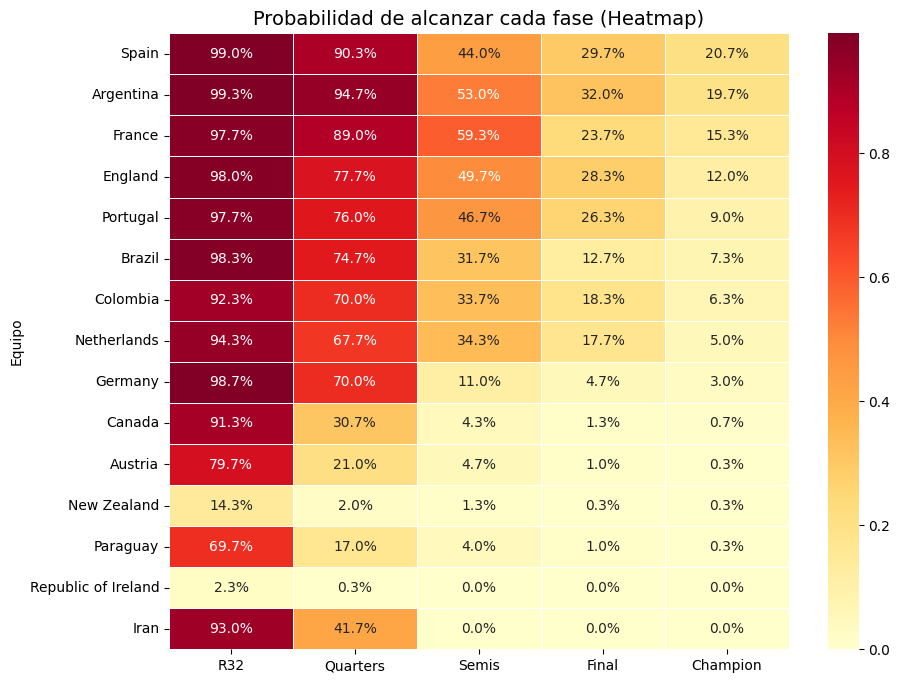

In [19]:
# Define una lista con los nombres de las columnas que representan las fases eliminatorias del torneo para filtrar el DataFrame.
cols_fases = ['R32', 'Quarters', 'Semis', 'Final', 'Champion']

# Ordena el DataFrame por la probabilidad de ser campeón, selecciona los 15 mejores y establece la columna 'Team' como el índice de las filas.
top_teams_heat = df_probs.sort_values("Champion", ascending=False).head(15).set_index('Team')

# Inicializa la figura de Matplotlib y define sus dimensiones de ancho y alto en pulgadas.
plt.figure(figsize=(10, 8))

# Genera el mapa de calor con el subconjunto de fases, activa las etiquetas numéricas, aplica formato porcentual y define la paleta de colores.
sns.heatmap(top_teams_heat[cols_fases], annot=True, fmt=".1%", cmap="YlOrRd", linewidths=.5)

# Asigna un título de encabezado al gráfico y configura el tamaño de la fuente para su visualización.
plt.title("Probabilidad de alcanzar cada fase (Heatmap)", fontsize=14)

# Define la etiqueta descriptiva para el eje vertical que contiene los nombres de las selecciones.
plt.ylabel("Equipo") 

# Ejecuta el comando para renderizar y mostrar el gráfico final en la salida del programa.
plt.show()

### 🔥 Mapa de Calor: Probabilidad de Progreso por Equipo

Este gráfico visualiza la "esperanza de vida" de cada selección en el torneo, ordenadas jerárquicamente por su desempeño promedio en la fase de grupos por puntos obtenidos.

* **Lectura del Gráfico:**
    * **Eje Vertical (Y):** Los equipos mejor clasificados en la fase de grupos aparecen arriba, mostrando sus puntos promedio entre paréntesis.
    * **Eje Horizontal (X):** Las fases del torneo, desde 16avos de final (R32) hasta Campeón.
    * **Intensidad de Color:** Los tonos más oscuros (rojo/naranja) indican una alta probabilidad de alcanzar esa instancia.

* **Interpretación Clave:**
    * **Consistencia:** Permite identificar a los equipos "seguros". Un equipo con casillas oscuras hasta *Quarters* o *Semis* es un rival muy difícil de eliminar temprano.
    * **Candidatos al Título:** Solo los equipos que mantienen colores intensos en la columna final (**Champion**) son los verdaderos favoritos para levantar la copa.
    * **Correlación:** Al ordenar por puntos, podemos ver si hacer una fase de grupos perfecta (9 pts) se traduce realmente en ganar el mundial, o si hay equipos que empiezan flojos pero crecen en la fase final.

In [22]:
# Define una lista con las etiquetas de las fases eliminatorias que se mostrarán en el eje X del gráfico.
phases = ['R32', 'Quarters', 'Semis', 'Final', 'Champion']

# Extrae los nombres de los primeros 5 equipos del DataFrame 'top15' y los convierte en una lista de Python.
top15 = df_probs.head(15)
# Extrae los nombres de los primeros 5 equipos
top5 = top15.head(5)['Team'].tolist()

# Inicializa una lista vacía para almacenar los diccionarios con los datos estructurados para el gráfico.
data_phases = []

# Inicia un bucle que recorre cada uno de los 5 equipos seleccionados.
for team in top5:
    # Filtra el DataFrame 'df_probs' para obtener la fila correspondiente al equipo actual.
    team_data = df_probs[df_probs['Team'] == team].iloc[0]
    
    # Inicia un bucle interno para recorrer cada fase del torneo.
    for phase in phases:
        # Agrega un diccionario a la lista 'data_phases' con el nombre del equipo, la fase y la probabilidad convertida a porcentaje.
        data_phases.append({ 
            'Team': team,
            'Phase': phase,
            'Probability': team_data[phase] * 100
        })

# Convierte la lista de diccionarios en un nuevo DataFrame de Pandas optimizado para herramientas de visualización.
df_phases = pd.DataFrame(data_phases)

# Crea un gráfico de líneas interactivo utilizando Plotly Express, asignando ejes, colores por equipo y activando marcadores en los puntos.
fig2 = px.line(
    df_phases,
    x='Phase',
    y='Probability',
    color='Team',
    title='📊 Progresión de Top 5 Candidatos por Fase',
    markers=True
)

# Actualiza el diseño del gráfico definiendo el título del eje vertical y estableciendo la altura de la figura en píxeles.
fig2.update_layout(yaxis_title='Probabilidad (%)', height=500)

# Renderiza y muestra el gráfico interactivo final en la interfaz.
fig2.show()

### 📉 Línea de Supervivencia: El Camino de los Candidatos

Este gráfico de líneas traza la trayectoria de los 5 máximos favoritos a lo largo de las distintas etapas del torneo, mostrando cómo se reduce su probabilidad de supervivencia ronda tras ronda.

* **Ejes del Gráfico:**
    * **Eje X (Fases):** Las etapas del Mundial, desde el inicio (100% vivos) hasta la Final.
    * **Eje Y (Probabilidad Acumulada):** La chance de que el equipo siga "vivo" en el torneo en esa fase específica.

* **Interpretación Clave:**
    * **La Pendiente del Peligro:** Una línea que se mantiene alta y recta indica un camino relativamente sencillo. Una línea que cae bruscamente (una pendiente pronunciada) en una fase temprana (ej. R16 o Quarters) sugiere un "cruce de la muerte" donde el favorito probablemente se enfrente a otro gigante y corra riesgo de eliminación.
    * **El Favorito Absoluto:** El equipo cuya línea termina más alta en la fase de "Champion" es el que ha demostrado mayor consistencia y superioridad en las miles de simulaciones.
    * **Convergencia:** Es normal ver que las líneas se cruzan. Un equipo puede tener muchas chances de llegar a semis (línea alta al principio) pero pocas de ganar la final (caída al final), revelando que es un equipo sólido pero quizás no campeón.

In [23]:

# Crea un gráfico de barras utilizando la librería Plotly Express con los datos seleccionados.
fig = px.bar(
    top15,
    x='Team',                                     # Asigna la columna 'Team' al eje horizontal (X).
    y='Champion',                                 # Asigna la columna 'Champion' al eje vertical (Y).
    title='⚽ Probabilidad de Ganar el Mundial 2026', # Establece el título principal del gráfico.
    labels={'Champion': 'Probabilidad', 'Team': 'País'}, # Define las etiquetas personalizadas para los ejes y leyendas.
    color='Champion',                             # Asigna un color a las barras basado en los valores de la columna 'Champion'.
    color_continuous_scale='Viridis'              # Aplica la escala de colores continua 'Viridis' al gráfico.
)

# Actualiza la configuración del diseño del gráfico.
fig.update_layout(
    yaxis_tickformat='.1%',                       # Configura el formato de los valores del eje Y como porcentaje con un decimal.
    height=500                                    # Establece la altura total de la figura en 500 píxeles.
)

# Ejecuta el comando para renderizar y mostrar el gráfico interactivo en la salida.
fig.show()

In [24]:
# Selecciona los primeros 30 registros del DataFrame 'bota_oro' para limitar la cantidad de datos en la visualización.
df_plot = bota_oro.head(30)

# Inicializa una figura de tipo scatter plot (gráfico de dispersión) utilizando la librería Plotly Express.
fig_scat = px.scatter(
    df_plot,                          # Define el DataFrame que contiene los datos a graficar.
    x='Expected_Games',               # Asigna la columna de partidos esperados al eje horizontal.
    y='goals_per_game_est',           # Asigna la columna de promedio de goles estimado al eje vertical.
    size='Projected_Goals',           # Define que el tamaño de los marcadores sea proporcional a los goles proyectados.
    color='team',                     # Asigna un color distinto a los marcadores según la columna de equipo.
    hover_name='scorer',              # Establece el nombre del goleador como etiqueta principal al pasar el cursor.
    title='Candidatos Bota de Oro: Oportunidad vs Eficacia', # Define el título superior del gráfico.
    labels={                          # Mapea los nombres de las columnas a etiquetas legibles en los ejes y leyendas.
        'Expected_Games': 'Partidos Esperados (Que tan lejos llega su equipo)',
        'goals_per_game_est': 'Promedio de Goles (Ritmo Goleador)',
        'team': 'Selección',
        'Projected_Goals': 'Goles Totales'
    },
    size_max=40                       # Establece el diámetro máximo en píxeles para los marcadores más grandes.
)

# Agrega una línea de referencia vertical en el valor 3 del eje X para indicar el límite de la fase de grupos.
fig_scat.add_vline(x=3, line_width=1, line_dash="dash", line_color="grey")

# Ejecuta el comando para renderizar y mostrar el gráfico interactivo en la salida del entorno.
fig_scat.show()

## 9️⃣ Exportar Resultados

In [25]:
# --- 1. DICCIONARIO DE TRADUCCIÓN (Inglés -> Español) ---
# Mapeo manual para que los reportes salgan en nuestro idioma.
trans_dict = {
    'Argentina': 'Argentina', 'France': 'Francia', 'Brazil': 'Brasil', 'England': 'Inglaterra',
    'Spain': 'España', 'Germany': 'Alemania', 'Portugal': 'Portugal', 'Netherlands': 'Países Bajos',
    'Belgium': 'Bélgica', 'Italy': 'Italia', 'Uruguay': 'Uruguay', 'Colombia': 'Colombia',
    'Croatia': 'Croacia', 'Morocco': 'Marruecos', 'USA': 'Estados Unidos', 'Mexico': 'México',
    'Senegal': 'Senegal', 'Japan': 'Japón', 'Switzerland': 'Suiza', 'Denmark': 'Dinamarca',
    'South Korea': 'Corea del Sur', 'Iran': 'Irán', 'Australia': 'Australia', 'Ukraine': 'Ucrania',
    'Nigeria': 'Nigeria', 'Sweden': 'Suecia', 'Poland': 'Polonia', 'Austria': 'Austria',
    'Hungary': 'Hungría', 'Serbia': 'Serbia', 'Ecuador': 'Ecuador', 'Chile': 'Chile',
    'Russia': 'Rusia', 'Czech Republic': 'República Checa', 'Chequia': 'Chequia', 'Norway': 'Noruega',
    'Egypt': 'Egipto', 'Cameroon': 'Camerún', 'Turkey': 'Turquía', 'Wales': 'Gales',
    'Costa Rica': 'Costa Rica', 'Canada': 'Canadá', 'Paraguay': 'Paraguay', 'Peru': 'Perú',
    'Ivory Coast': 'Costa de Marfil', 'Algeria': 'Argelia', 'Tunisia': 'Túnez', 'Saudi Arabia': 'Arabia Saudita',
    'Ghana': 'Ghana', 'Jamaica': 'Jamaica', 'Panama': 'Panamá', 'South Africa': 'Sudáfrica',
    'Qatar': 'Catar', 'New Zealand': 'Nueva Zelanda', 'Uzbekistan': 'Uzbekistán', 'Haiti': 'Haití',
    'Bolivia': 'Bolivia', 'Venezuela': 'Venezuela', 'Honduras': 'Honduras', 'Iraq': 'Irak',
    'Iceland': 'Islandia', 'Bosnia and Herzegovina': 'Bosnia', 'Slovakia': 'Eslovaquia',
    'Romania': 'Rumania', 'Ireland': 'Irlanda', 'Greece': 'Grecia', 'Slovenia': 'Eslovenia',
    'North Macedonia': 'Macedonia del Norte', 'Albania': 'Albania', 'Finland': 'Finlandia'
}

# --- 2. FUNCIÓN DE EXPORTACIÓN ---
def translate_and_export(df, columns_to_translate, file_name):
    """Traduce las columnas especificadas de un DataFrame y exporta a CSV."""
    df_out = df.copy() # Trabajamos sobre una copia para no alterar los datos originales en memoria
    
    # Aseguramos que sea una lista para poder iterar, incluso si es solo una columna
    if isinstance(columns_to_translate, str):
        columns_to_translate = [columns_to_translate]
    
    # Proceso de traducción
    for col in columns_to_translate:
        if col in df_out.columns:
            # .map() busca en el diccionario. .fillna() mantiene el nombre original si no encuentra traducción.
            df_out[col] = df_out[col].map(trans_dict).fillna(df_out[col])
    
    # Guardado: 'utf-8-sig' es vital para que Excel abra bien las tildes y caracteres especiales
    df_out.to_csv(f"{file_name}.csv", index=False, encoding='utf-8-sig')
    print(f"-> Archivo generado: {file_name}.csv")
    return df_out

print("Iniciando generación de reportes en Español...")

# A) Top Candidatos al Título

top_candidates_es = translate_and_export(df_display.head(30), 'Team', '1_Candidatos_Titulo_Mundial')

# B) Equipos más agresivos (Tarjetas)


cards_es = translate_and_export(discipline_proj.head(20), 'Team', '2_Ranking_Tarjetas')

# C) Bota de Oro (Goleadores)

scorers_es = translate_and_export(
    bota_oro.sort_values('Projected_Goals', ascending=False).head(15), 
    'team',  # Usamos 'Team' (Mayúscula) porque esa columna viene del merge con df_probs
    '3_Candidatos_Bota_Oro'
)

# D) Ganadores de Grupo y Clasificados

df_qualified = pd.DataFrame(qual) # <--- Paso extra necesario
qualified_es = translate_and_export(
    df_qualified, 
    ['1er Clasificado', '2do Clasificado'], 
    '4_Clasificados_Ronda_32'
)
# E) Grupo de la Muerte
# Variable origen: df_group_difficulty (Viene de la celda de análisis de grupos)

death_es = translate_and_export(df_group_difficulty, 'Top_Seed', '5_Dificultad_Grupos')

# F) Guante de Oro (Arqueros)

glove_es = translate_and_export(df_golden_glove.head(20), 'Team', '6_Candidatos_Guante_Oro')

print("\n✅ ¡Proceso finalizado! Todos los archivos CSV están listos en la carpeta.")

Iniciando generación de reportes en Español...
-> Archivo generado: 1_Candidatos_Titulo_Mundial.csv
-> Archivo generado: 2_Ranking_Tarjetas.csv
-> Archivo generado: 3_Candidatos_Bota_Oro.csv
-> Archivo generado: 4_Clasificados_Ronda_32.csv
-> Archivo generado: 5_Dificultad_Grupos.csv
-> Archivo generado: 6_Candidatos_Guante_Oro.csv

✅ ¡Proceso finalizado! Todos los archivos CSV están listos en la carpeta.
